In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim, utils
from torchvision import models, datasets, transforms

import PIL.Image as Image
from mini_resnet import TinyResNet

from tqdm import tqdm
import random
import cv2
import os

import matplotlib.pyplot as plt

import time

plt.rcParams['figure.figsize'] = (10,10)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using device ...", device)

Using device ... cuda


ImageNet

- mean = [0.485, 0.456, 0.406],
    
- std = [0.229, 0.224, 0.225]

ImageNet - Birds

- mean = [0.41394996 0.4793801  0.4704038 ]

- std = [0.21167022 0.20279775 0.2035766 ]

torch.Size([64, 3, 28, 28])


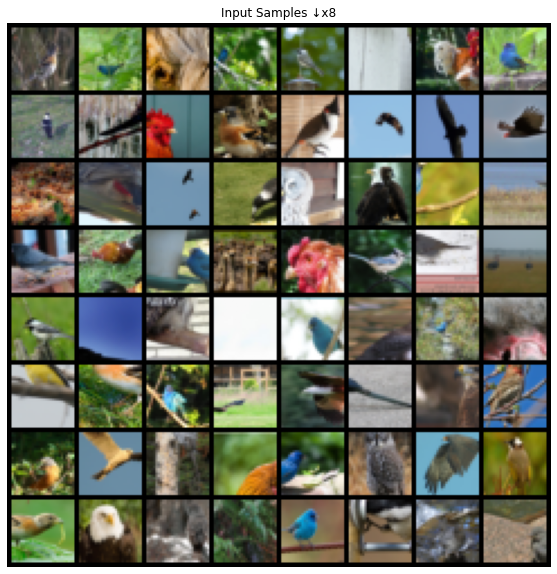

In [2]:
init_scale = 1.15

down_scale = 8

normalize = transforms.Normalize(mean=mean,
                                     std=std)

transforms_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224//down_scale),
    transforms.ToTensor(),
])

transforms_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Resize(224//down_scale),
    transforms.ToTensor(),
])
    
train_dataset = datasets.ImageFolder("../dataset/ILSVRC_Birds/train", transform=transforms_train)
train_loader = utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8)

test_dataset = datasets.ImageFolder("../dataset/ILSVRC_Birds/val", transform=transforms_test)
test_loader = utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=8)
# Show samples

# batch_sample = next(iter(train_loader))
# print(batch_sample[0].shape)
# image_samples = torchvision.utils.make_grid(batch_sample[0],nrow=8).permute((1,2,0))

# fig, ax = plt.subplots()
# ax.axis('off')
# ax.imshow(image_samples)
# ax.set_title(f"Input Samples ↓x{down_scale}")
# plt.savefig("./batch_samples.jpg")

In [3]:
def get_model(model, pretrained=False, num_classes = 6):
    if model == 'resnet152':
        net = models.resnet152(pretrained=pretrained)
        net.fc = nn.Linear(in_features=2048, out_features=num_classes)
    elif model == 'resnet18':
        net = models.resnet18(pretrained=pretrained)
        net.fc = nn.Linear(in_features=512, out_features=num_classes)
    elif model == 'TinyResNet':
        net = TinyResNet(pretrained=pretrained)
        net.fc = nn.Linear(in_features=512, out_features=num_classes)
    else:
        print(f"Unsupported model : {model}")
    return net
teacher_arch = 'resnet18'
# student_arch = 'TinyResNet'
net_t = get_model(teacher_arch, pretrained=True, num_classes=18)
# net_s = get_model(student_arch, pretrained=False, num_classes=6)
net_t = net_t.to(device)
# net_s = net_s.to(device)

In [4]:
def train(net, train_loader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(),lr=1e-4, weight_decay=4e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, 50, gamma=0.1)
    
    train_avg_loss = 0
    n_count = 0
    n_corrects = 0

    net.train()

    for j, data in enumerate(train_loader):
        batch, label = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        pred = net(batch)

        loss = criterion(pred, label)
        train_avg_loss += loss

        n_corrects += torch.sum(torch.argmax(pred, dim=1) == label).item()
        n_count += label.shape[0]

        loss.backward()
        optimizer.step()

    train_accuracy = n_corrects/n_count
    train_avg_loss /= n_count

    return train_accuracy, train_avg_loss, net

In [5]:
def evaluate(net ,test_loader):
    net.eval()
    
    n_count = 0
    n_corrects = 0

    for j, data in enumerate(test_loader):


        batch, label = data[0].to(device), data[1].to(device)

        pred = net(batch)

        n_corrects += torch.sum(torch.argmax(pred, dim=1) == label).item()
        n_count += label.shape[0]

    test_accuracy = n_corrects/n_count
    
    return test_accuracy, net

Test Accuracy
- Mosquito Test
    - x1 : 97.20%
    - x2 : 97.80%
    - x4 : 95.06%
    - x8 : 93.82%
    - x16 : 89.26%
    - x32 : 72.06%
- ILSVRC2012 Birds (Training%)
    - x1 : 93.22% (99%)
    - x2 : 89.11% (95%)
    - x4 : 81.78% (90%)
    - x8 : 66.68% (70%)

In [6]:
def train_and_eval(net, epochs, train_loader, test_loader, save_name='default.pth'):
    print("─── Start Training & Evalutation ───")
    
    best_accuracy = 0
    best_model = None
    
    for i in range(epochs):
        
        time_start = time.time()
        print(f"┌ Epoch ({i}/{epochs-1})")
        
        train_acc, loss, net = train(net, train_loader)
        print(f"├── Training Loss : {loss:.4f}")
        print(f'├── Training accuracy : {train_acc*100:.2f}%')
        print("│ Testing ...")
        test_acc, net = evaluate(net, test_loader)
        print(f'└── Testing accuracy : {test_acc*100:.2f}%')
        
        if test_acc > best_accuracy:
            print(f"  └──> Saving the best model to \"{save_name}\"")
            best_accuracy = test_acc
            best_model = net
            model_dict = {'acc':best_accuracy, 'net':best_model}
            torch.save(model_dict, save_name)
            
        time_end = time.time()
        epoch_time = time_end - time_start
        epoch_time_gm = time.gmtime(epoch_time)
        estimated_time = epoch_time * (epochs - 1 - i)
        estimated_time_gm = time.gmtime(estimated_time)
        
        print(f"Epoch time ─ {epoch_time_gm.tm_hour}[h] {epoch_time_gm.tm_min}[m] {epoch_time_gm.tm_sec}[s]")
        print(f"Estimated time ─ {estimated_time_gm.tm_hour}[h] {estimated_time_gm.tm_min}[m] {estimated_time_gm.tm_sec}[s]")
        print("\n")
            
    return best_accuracy, best_model
        
epochs = 150

accuracy, net_t = train_and_eval(net_t, epochs, train_loader, test_loader, save_name=f"./Birds_model/{teacher_arch}_x{down_scale}.pth")


─── Start Training & Evalutation ───
┌ Epoch (0/149)
├── Training Loss : 0.0349
├── Training accuracy : 31.75%
│ Testing ...
└── Testing accuracy : 44.11%
  └──> Saving the best model to "./Birds_model/resnet18_x8.pth"
Epoch time ─ 0[h] 0[m] 12[s]
Estimated time ─ 0[h] 32[m] 15[s]


┌ Epoch (1/149)
├── Training Loss : 0.0287
├── Training accuracy : 43.58%
│ Testing ...
└── Testing accuracy : 48.56%
  └──> Saving the best model to "./Birds_model/resnet18_x8.pth"
Epoch time ─ 0[h] 0[m] 12[s]
Estimated time ─ 0[h] 31[m] 59[s]


┌ Epoch (2/149)
├── Training Loss : 0.0264
├── Training accuracy : 47.53%
│ Testing ...
└── Testing accuracy : 52.56%
  └──> Saving the best model to "./Birds_model/resnet18_x8.pth"
Epoch time ─ 0[h] 0[m] 13[s]
Estimated time ─ 0[h] 31[m] 56[s]


┌ Epoch (3/149)
├── Training Loss : 0.0252
├── Training accuracy : 49.73%
│ Testing ...
└── Testing accuracy : 55.44%
  └──> Saving the best model to "./Birds_model/resnet18_x8.pth"
Epoch time ─ 0[h] 0[m] 13[s]
Estimated t